# Proyecto de aula: Análisis del IPC en Medellín


# Análisis Predictivo de Datos
## Proyecto de aula: Análisis del IPC en Medellín


### Integrantes

- Alejandro Córdoba Ríos
- Juan Camilo Manjarrés Baena
- Adrián David Perdomo Echeverri


### Descripción

Este proyecto de aula busca hacer un análisis histórico de los datos proporcionados por el **Departamento Administrativo Nacional de Estadísticas (DANE)** con respecto al **Índice de Precios al Consumidor (IPC)**, con el fin de predecir la variación de este indicador económico en el futuro. Se obtienen datos de la variación mensual del IPC total, por divisiones de bienes y servicios y categorizados por ciudades.

Se toman datos de los últimos 10 años (120 meses), desde septiembre de 2014 hasta agosto de 2024.

Las divisiones de bienes y servicios que identifica el DANE son:
- Total (IPC general sin categorizar)
- Alimentos y bebidas no alcohólicas
- Bebidas alcohólicas y tabaco
- Prendas de vestir y calzado
- Alojamiento, agua, electricidad, gas y otros combustibles
- Muebles, artículos para el hogar y para la conservación ordinaria del hogar
- Salud
- Transporte
- Información y comunicación
- Recreación y cultura
- Educación
- Restaurantes y hoteles
- Bienes y servicios diversos

*NOTA: Las categorías varían según los años. Para el conjunto de datos de 5 años atrás y 10 años atrás, la cantidad y nombres de las categorías varían significativamente.*


Y las ciudades listadas son:
- Nacional (IPC total en Colombia)
- Medellín
- Barranquilla
- Bogotá, D.C.
- Cartagena De Indias
- Tunja
- Manizales
- Florencia
- Popayán
- Valledupar
- Montería
- Neiva
- Riohacha
- Santa Marta
- Villavicencio
- Pasto
- Cúcuta
- Armenia
- Pereira
- Bucaramanga
- Sincelejo
- Ibagué
- Cali
- Otras Areas Urbanas

*NOTA: La cantidad y ciudades listadas también cambian en algunos períodos. Sin embargo, las ciudades principales se encuentran en todos los períodos.*

Los datos se obtienen del sitio oficial del DANE: https://www.dane.gov.co/index.php/comunicados-y-boletines/indice-de-precios-y-costos/ipc

## Objetivos

Los objetivos del proyecto están alineados con el proposito de tener una idea de qué camino sigue la economía de la ciudad y nosotros como habitantes saber cómo podemos reaccionar al respecto.

Los principales objetivos son:
- Interpretar el IPC en su correspondiente fecha.
- Identificar cómo la temporalidad afecta la economía.
- Predecir lo que podría suceder después teniendo en cuenta los datos actuales.

## Recolección de los datos

Se obtienen los anexos de los reportes históricos mensuales que se encuentran en el enlace citado anteriormente, los cuales son documentos con formato *.xlsx* (*.xls* para los reportes más antiguos). Estos archivos de Excel contienen varias hojas con información ordenada y categorizada de distintas maneras, pero para el objetivo del proyecto de aula, nos concentraremos en los datos de la **hoja "4"**, que corresponde a **"Variación mensual, total y por divisiones de bienes y servicios, según ciudades"**.

Como son en total 120 archivos (un archivo por cada mes, desde septiembre de 2014 hasta agosto de 2024) y lo ideal es tener todos los datos en un solo archivo, vamos a iterar cada archivo para obtener su información e irla recolectando y ordenando en un archivo final con formato *.csv*. Se renombraron los archivos para seguir una convención específica, que nos servirá para que en la iteración se identifique a qué mes y año corresponde la información. Esta convención es *año-mes.xlsx*, donde año es el número con 4 dígitos y mes es el número con 2 dígitos (por ejemplo: *2023-07.xlsx*, que corresponde a julio del 2023).

Al final esperamos tener un único archivo con formato *.csv* donde cada fila contenga la siguiente información:
- Ciudad [texto]
- Categoría (división de bienes y servicios) [texto]
- Año [número]
- Mes [número]
- IPC [número]

## Importar librerías necesarias

In [89]:
# Para Google Colab (descomentar las siguientes líneas)
# %pip install kagglehub
# %pip install xgboost
# %pip install lightgbm
# %pip install catboost

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import mean_absolute_percentage_error

## Carga de datos desde kaggle

https://www.kaggle.com/datasets/alejandrocrdobaros/ipc-from-september-2022-to-august-2024-by-dane/


In [91]:
path = kagglehub.dataset_download("alejandrocrdobaros/ipc-from-september-2022-to-august-2024-by-dane", path='ipc_from_2014-09_to_2024-08.csv')

df = pd.read_csv(path)
df.head()

,city,category,ipc,year,month
0,Nacional,Alimentos,0.16,2014,9
1,Medellín,Alimentos,0.02,2014,9
2,Barranquilla,Alimentos,0.27,2014,9
3,Bogotá,Alimentos,0.22,2014,9
4,Cartagena,Alimentos,0.35,2014,9


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34216 entries, 0 to 34215
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   city      34216 non-null  object 
 1   category  34216 non-null  object 
 2   ipc       34216 non-null  float64
 3   year      34216 non-null  int64  
 4   month     34216 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.3+ MB


# Seleccionar datos
Por la complejidad de realizar un forecasting con datos de distintas ciudades y con diferentes ciudades, se tomara como muestra, la categoria total y la ciudad medellin para verificar si es posible realizar un modelo efectivo


In [93]:
df = df.loc[(df['city'] == 'Medellín') & (df['category'] == 'Total')]
df.head()

,city,category,ipc,year,month
226,Medellín,Total,0.18,2014,9
476,Medellín,Total,0.19,2014,10
726,Medellín,Total,0.20,2014,11
976,Medellín,Total,0.31,2014,12
1226,Medellín,Total,1.03,2015,1


Se elimina la columna 'city' y 'category' porque no son un dato importante en este caso para realizar las predicciones, ya que todos los datos filtrados tienen estas características en común

In [94]:
df = df.drop(columns=['city', 'category'])
df.head()

,ipc,year,month
226,0.18,2014,9
476,0.19,2014,10
726,0.20,2014,11
976,0.31,2014,12
1226,1.03,2015,1


Crear index de tiempo


In [95]:
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df.set_index('date', inplace=True)

<Axes: xlabel='date'>

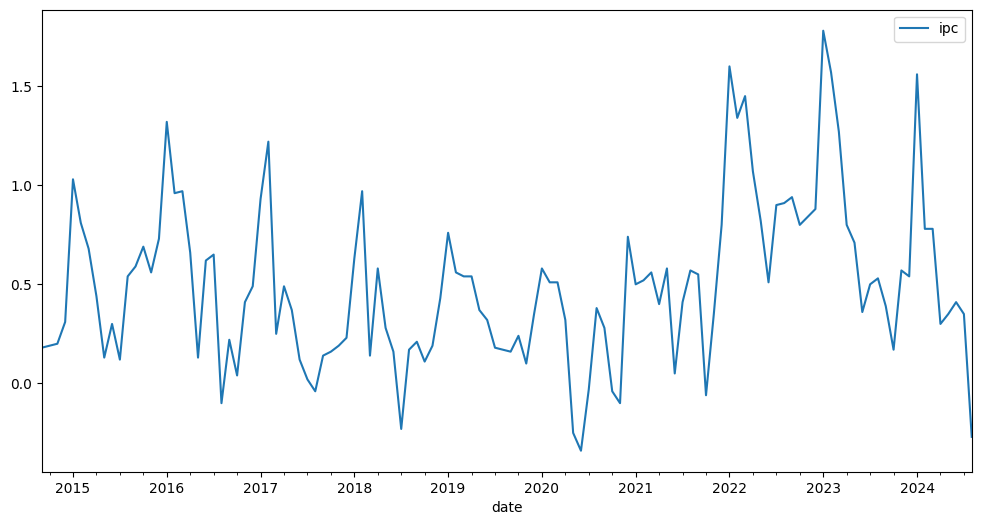

In [96]:
df.plot(y='ipc', figsize=(12, 6))

In [97]:
df['ipc'].describe()

count    120.000000
mean       0.493167
std        0.409605
min       -0.340000
25%        0.190000
50%        0.465000
75%        0.715000
max        1.780000
Name: ipc, dtype: float64

Generación de nuevas caracteristicas

Se realiza un retardo de 12 meses para generar mas características y mejorar la precisión de las predicciones

In [98]:
retardo = 12

for i in range(retardo):
  df[f'ipc-{i+1}'] = df['ipc'].shift(i+1)

df.dropna(inplace=True)
df.head()

,ipc,year,month,ipc-1,ipc-2,ipc-3,ipc-4,ipc-5,ipc-6,ipc-7,ipc-8,ipc-9,ipc-10,ipc-11,ipc-12
date,,,,,,,,,,,,,,,
2015-09-01,0.59,2015,9,0.54,0.12,0.30,0.13,0.44,0.68,0.81,1.03,0.31,0.20,0.19,0.18
2015-10-01,0.69,2015,10,0.59,0.54,0.12,0.30,0.13,0.44,0.68,0.81,1.03,0.31,0.20,0.19
2015-11-01,0.56,2015,11,0.69,0.59,0.54,0.12,0.30,0.13,0.44,0.68,0.81,1.03,0.31,0.20
2015-12-01,0.73,2015,12,0.56,0.69,0.59,0.54,0.12,0.30,0.13,0.44,0.68,0.81,1.03,0.31
2016-01-01,1.32,2016,1,0.73,0.56,0.69,0.59,0.54,0.12,0.30,0.13,0.44,0.68,0.81,1.03


In [99]:
df.tail()

,ipc,year,month,ipc-1,ipc-2,ipc-3,ipc-4,ipc-5,ipc-6,ipc-7,ipc-8,ipc-9,ipc-10,ipc-11,ipc-12
date,,,,,,,,,,,,,,,
2024-04-01,0.30,2024,4,0.78,0.78,1.56,0.54,0.57,0.17,0.39,0.53,0.50,0.36,0.71,0.80
2024-05-01,0.35,2024,5,0.30,0.78,0.78,1.56,0.54,0.57,0.17,0.39,0.53,0.50,0.36,0.71
2024-06-01,0.41,2024,6,0.35,0.30,0.78,0.78,1.56,0.54,0.57,0.17,0.39,0.53,0.50,0.36
2024-07-01,0.35,2024,7,0.41,0.35,0.30,0.78,0.78,1.56,0.54,0.57,0.17,0.39,0.53,0.50
2024-08-01,-0.27,2024,8,0.35,0.41,0.35,0.30,0.78,0.78,1.56,0.54,0.57,0.17,0.39,0.53


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2015-09-01 to 2024-08-01
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ipc     108 non-null    float64
 1   year    108 non-null    int64  
 2   month   108 non-null    int64  
 3   ipc-1   108 non-null    float64
 4   ipc-2   108 non-null    float64
 5   ipc-3   108 non-null    float64
 6   ipc-4   108 non-null    float64
 7   ipc-5   108 non-null    float64
 8   ipc-6   108 non-null    float64
 9   ipc-7   108 non-null    float64
 10  ipc-8   108 non-null    float64
 11  ipc-9   108 non-null    float64
 12  ipc-10  108 non-null    float64
 13  ipc-11  108 non-null    float64
 14  ipc-12  108 non-null    float64
dtypes: float64(13), int64(2)
memory usage: 13.5 KB


#Separar el dataframe

Se separa el dataset en los dataframes de entrenamiento y de prueba correspondientes para realizar el proceso de entrenamiento y sacar metricas, se va a usar una ventana de 22 meses, para tener una proporcion aproximada de 80% de los datos para entrenamiento y 20% para pruebas

(86, 14)
(22, 14)
(86,)
(22,)


C:\Users\alejo\AppData\Local\Temp\ipykernel_25512\1388983112.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train.drop(columns='ipc', inplace=True)
C:\Users\alejo\AppData\Local\Temp\ipykernel_25512\1388983112.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test.drop(columns='ipc', inplace=True)


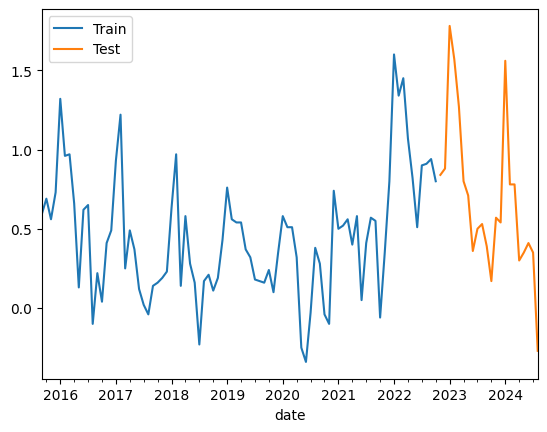

In [101]:
x_train = df[:-22]
x_test =  df[-22:]
y_train = df[:-22]["ipc"]
y_test =  df[-22:]["ipc"]

x_train.drop(columns='ipc', inplace=True)
x_test.drop(columns='ipc', inplace=True)
y_train.plot(label='Train')
y_test.plot(label='Test')
plt.legend()
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape )

In [102]:
x_train.head()

,year,month,ipc-1,ipc-2,ipc-3,ipc-4,ipc-5,ipc-6,ipc-7,ipc-8,ipc-9,ipc-10,ipc-11,ipc-12
date,,,,,,,,,,,,,,
2015-09-01,2015,9,0.54,0.12,0.30,0.13,0.44,0.68,0.81,1.03,0.31,0.20,0.19,0.18
2015-10-01,2015,10,0.59,0.54,0.12,0.30,0.13,0.44,0.68,0.81,1.03,0.31,0.20,0.19
2015-11-01,2015,11,0.69,0.59,0.54,0.12,0.30,0.13,0.44,0.68,0.81,1.03,0.31,0.20
2015-12-01,2015,12,0.56,0.69,0.59,0.54,0.12,0.30,0.13,0.44,0.68,0.81,1.03,0.31
2016-01-01,2016,1,0.73,0.56,0.69,0.59,0.54,0.12,0.30,0.13,0.44,0.68,0.81,1.03


In [103]:
y_train.head()

date
2015-09-01    0.59
2015-10-01    0.69
2015-11-01    0.56
2015-12-01    0.73
2016-01-01    1.32
Name: ipc, dtype: float64

In [104]:
x_test.head()

,year,month,ipc-1,ipc-2,ipc-3,ipc-4,ipc-5,ipc-6,ipc-7,ipc-8,ipc-9,ipc-10,ipc-11,ipc-12
date,,,,,,,,,,,,,,
2022-11-01,2022,11,0.80,0.94,0.91,0.90,0.51,0.82,1.07,1.45,1.34,1.60,0.80,0.35
2022-12-01,2022,12,0.84,0.80,0.94,0.91,0.90,0.51,0.82,1.07,1.45,1.34,1.60,0.80
2023-01-01,2023,1,0.88,0.84,0.80,0.94,0.91,0.90,0.51,0.82,1.07,1.45,1.34,1.60
2023-02-01,2023,2,1.78,0.88,0.84,0.80,0.94,0.91,0.90,0.51,0.82,1.07,1.45,1.34
2023-03-01,2023,3,1.57,1.78,0.88,0.84,0.80,0.94,0.91,0.90,0.51,0.82,1.07,1.45


# XGBRegressor

In [105]:
ts_cv = TimeSeriesSplit(n_splits=5)
xgb_model = XGBRegressor()
dist = {'n_estimators':range(1, 201), 'max_depth':range(1,20), 'learning_rate':loguniform(1e-2,1e0)}
grid_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=dist, cv=ts_cv, scoring='neg_root_mean_squared_error', n_iter=100, random_state=42)
grid_search.fit(x_train, y_train)

best_model_xgb = grid_search.best_estimator_

test_error_xgb = mean_absolute_percentage_error(y_test, best_model_xgb.predict(x_test))
print(f'Best score: {-grid_search.best_score_:.4f} with {grid_search.best_params_}')
print(f'Test score: {test_error_xgb:.4f}')

Best score: 0.3306 with {'learning_rate': 0.021826570038901177, 'max_depth': 10, 'n_estimators': 54}
Test score: 0.6588


In [106]:
features_xgb = pd.DataFrame({'Feature': x_train.columns, 'Importance': best_model_xgb.feature_importances_})
features_xgb.sort_values(by='Importance', ascending=False).head(20)

,Feature,Importance
2,ipc-1,0.258801
8,ipc-7,0.164285
12,ipc-11,0.114074
13,ipc-12,0.083221
10,ipc-9,0.067532
3,ipc-2,0.066173
7,ipc-6,0.054983
1,month,0.052953
0,year,0.036767
11,ipc-10,0.033635


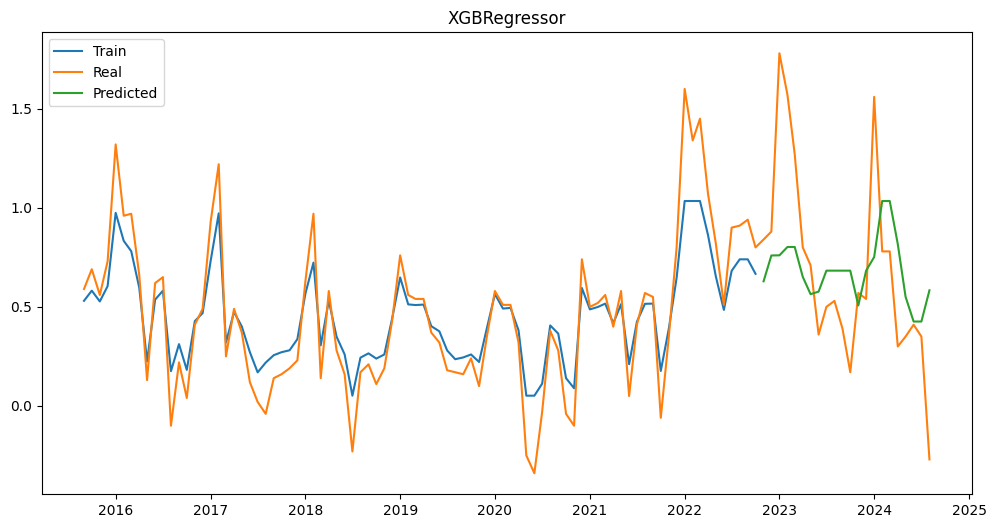

In [107]:
y_est_xgb = best_model_xgb.predict(x_train)
y_pred_xgb = best_model_xgb.predict(x_test)

plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_est_xgb, label='Train')
plt.plot(df['ipc'].index, df['ipc'], label='Real')
plt.plot(y_test.index, y_pred_xgb, label='Predicted')
plt.title('XGBRegressor')
plt.legend()

In [108]:
df["ipc"].describe()

count    108.000000
mean       0.502315
std        0.420391
min       -0.340000
25%        0.190000
50%        0.495000
75%        0.732500
max        1.780000
Name: ipc, dtype: float64

# LightGBM

In [109]:
LGBM = LGBMRegressor()

params_lgbm = {
    'n_estimators': range(1, 300, 2),
    'max_depth': range(10,60, 10),
    'learning_rate':loguniform(1e-4,1e0),
    'num_leaves': range(50, 100, 10),
}

random_search_lgbm = RandomizedSearchCV(
    estimator=LGBM,
    param_distributions=params_lgbm,
    scoring='neg_mean_absolute_percentage_error',
    cv=5,
    n_iter=10
)

random_search_lgbm.fit(x_train, y_train)

best_model_lgbm = random_search_lgbm.best_estimator_

test_error_lgbm = mean_absolute_percentage_error(y_test, best_model_lgbm.predict(x_test))
print(f'Best score: {-random_search_lgbm.best_score_:.4f} with {random_search_lgbm.best_params_}')
print(f'Test score: {test_error_lgbm:.4f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 68, number of used features: 14
[LightGBM] [Info] Start training from score 0.411618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [110]:
features_lgbm = pd.DataFrame({'Feature': x_train.columns, 'Importance': best_model_lgbm.feature_importances_})
features_lgbm.sort_values(by='Importance', ascending=False).head(20)

,Feature,Importance
7,ipc-6,6
11,ipc-10,6
0,year,4
1,month,4
2,ipc-1,4
10,ipc-9,4
13,ipc-12,4
3,ipc-2,3
4,ipc-3,3
9,ipc-8,3


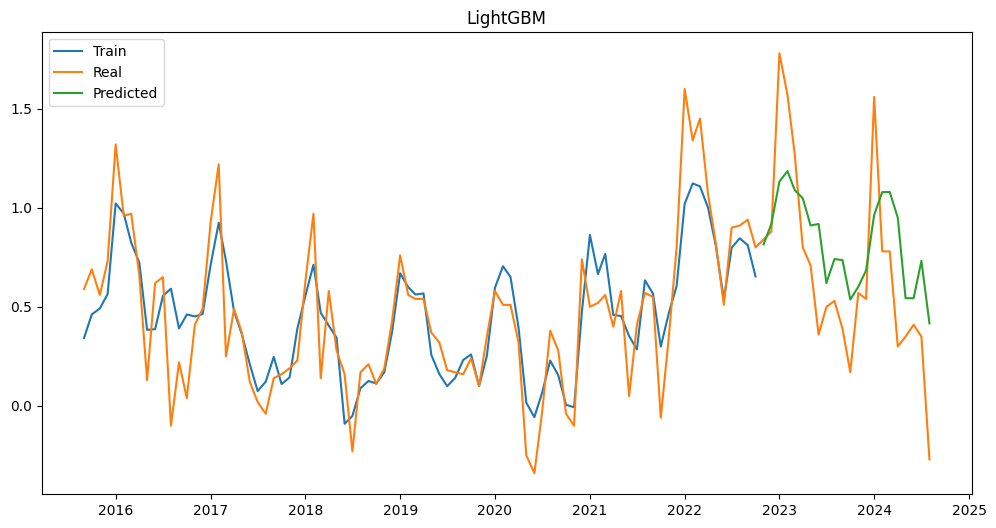

In [111]:
y_est_lgbm = best_model_lgbm.predict(x_train)
y_pred_lgbm = best_model_lgbm.predict(x_test)

plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_est_lgbm, label='Train')
plt.plot(df['ipc'].index, df['ipc'], label='Real')
plt.plot(y_test.index, y_pred_lgbm, label='Predicted')
plt.title('LightGBM')
plt.legend()

# CatBoostRegressor

In [125]:
CAT = CatBoostRegressor()

params_cat = {
    'n_estimators': range(1, 400),
    'depth': range(1,60),
    'learning_rate': loguniform(1e-2,1e0),
}

random_search_cat = RandomizedSearchCV(
    estimator=CAT,
    param_distributions=params_cat,
    scoring='neg_mean_absolute_percentage_error',
    cv=5,
    verbose=1,
    n_jobs=-1,
    n_iter=100,
    random_state=42
)

random_search_cat.fit(x_train, y_train)

best_model_cat = random_search_cat.best_estimator_

test_error_cat = mean_absolute_percentage_error(y_test, best_model_cat.predict(x_test))
print(f'Best score: {-random_search_cat.best_score_:.4f} with {random_search_cat.best_params_}')
print(f'Test score: {test_error_cat:.4f}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
0:	learn: 0.3813113	total: 487us	remaining: 63.3ms
1:	learn: 0.3757124	total: 719us	remaining: 46.4ms
2:	learn: 0.3711168	total: 904us	remaining: 38.6ms
3:	learn: 0.3668878	total: 1.09ms	remaining: 34.6ms
4:	learn: 0.3617649	total: 1.25ms	remaining: 31.6ms
5:	learn: 0.3565826	total: 1.39ms	remaining: 29ms
6:	learn: 0.3526289	total: 1.57ms	remaining: 27.8ms
7:	learn: 0.3489941	total: 1.68ms	remaining: 25.8ms
8:	learn: 0.3467885	total: 1.85ms	remaining: 25.1ms
9:	learn: 0.3428049	total: 2.04ms	remaining: 24.7ms
10:	learn: 0.3383190	total: 2.18ms	remaining: 23.8ms
11:	learn: 0.3361677	total: 2.35ms	remaining: 23.3ms
12:	learn: 0.3314763	total: 2.51ms	remaining: 22.8ms
13:	learn: 0.3281941	total: 2.67ms	remaining: 22.3ms
14:	learn: 0.3262467	total: 2.79ms	remaining: 21.6ms
15:	learn: 0.3229508	total: 2.93ms	remaining: 21ms
16:	learn: 0.3203442	total: 3.06ms	remaining: 20.5ms
17:	learn: 0.3174033	total: 3.19ms	remaining: 20ms
18

c:\Users\alejo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
330 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
330 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\alejo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\alejo\AppData\Local\Programs\Python\Python312\Lib\site-packages\catboost\core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, b

In [126]:
features_cat = pd.DataFrame({'Feature': x_train.columns, 'Importance': best_model_cat.feature_importances_})
features_cat.sort_values(by='Importance', ascending=False).head(20)

,Feature,Importance
2,ipc-1,27.946415
0,year,26.224285
1,month,25.844405
13,ipc-12,10.498798
12,ipc-11,4.899554
4,ipc-3,2.688466
7,ipc-6,0.684947
9,ipc-8,0.413764
8,ipc-7,0.369190
11,ipc-10,0.245391


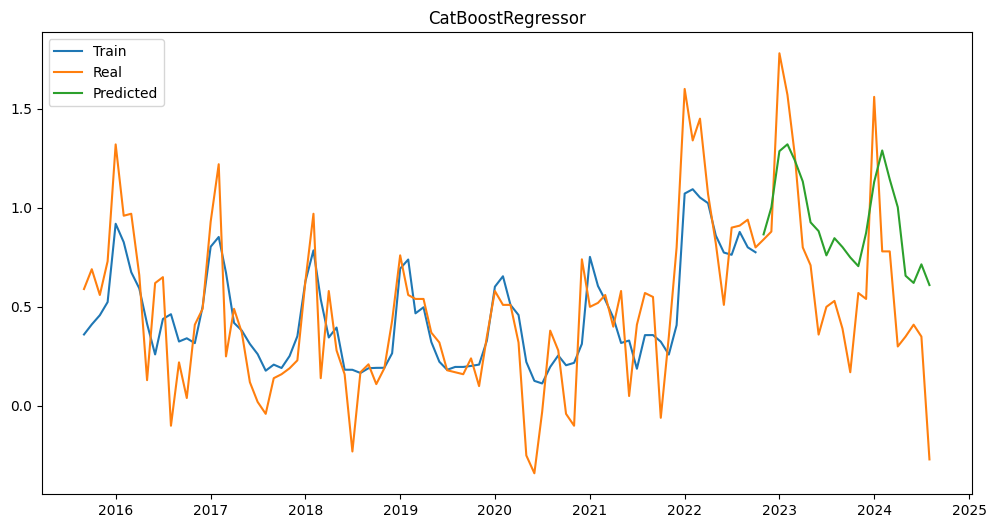

In [127]:
y_est_cat = best_model_cat.predict(x_train)
y_pred_cat = best_model_cat.predict(x_test)

plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_est_cat, label='Train')
plt.plot(df['ipc'].index, df['ipc'], label='Real')
plt.plot(y_test.index, y_pred_cat, label='Predicted')
plt.title('CatBoostRegressor')
plt.legend()

# Mejor modelo: XGBRegressor

El modelo que mejor resultados tiene es el primero: XGBRegressor. Mostraremos cuáles son las mejores características en este modelo y haremos una predicción a futuro usándolo, y así tener una idea de cómo será la variación mensual del IPC próximamente.

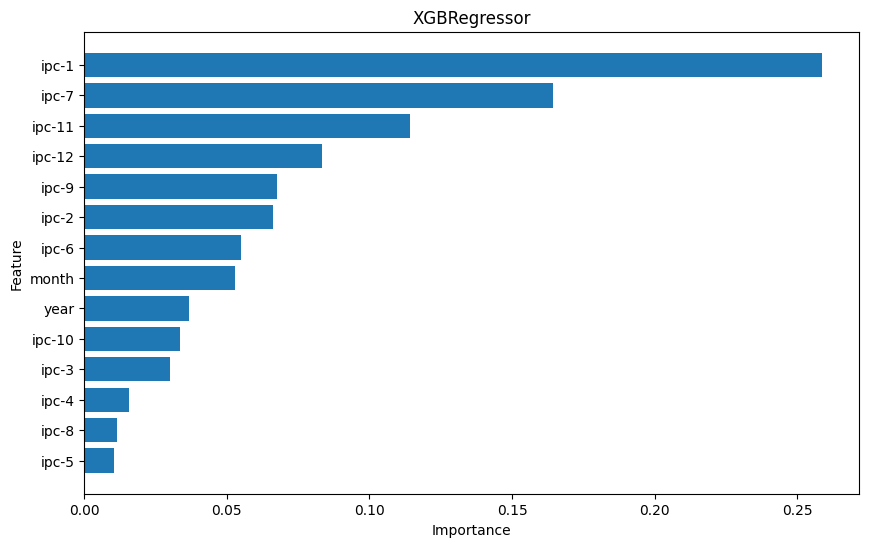

In [128]:
features_xgb.sort_values(by='Importance', ascending=False, inplace=True)
plt.figure(figsize=(10, 6))
plt.barh(features_xgb['Feature'], features_xgb['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBRegressor')
plt.gca().invert_yaxis()
plt.show()

## Predicción al siguiente periodo

Vamos a hacer una predicción usando el modelo que mejor resultados obtuvo (XGBRegressor) para los siguientes 5 meses:
- Septiembre de 2024
- Octubre de 2024
- Noviembre de 2024
- Diciembre de 2024
- Enero de 2025

In [129]:
df.tail()

,ipc,year,month,ipc-1,ipc-2,ipc-3,ipc-4,ipc-5,ipc-6,ipc-7,ipc-8,ipc-9,ipc-10,ipc-11,ipc-12
date,,,,,,,,,,,,,,,
2024-04-01,0.30,2024,4,0.78,0.78,1.56,0.54,0.57,0.17,0.39,0.53,0.50,0.36,0.71,0.80
2024-05-01,0.35,2024,5,0.30,0.78,0.78,1.56,0.54,0.57,0.17,0.39,0.53,0.50,0.36,0.71
2024-06-01,0.41,2024,6,0.35,0.30,0.78,0.78,1.56,0.54,0.57,0.17,0.39,0.53,0.50,0.36
2024-07-01,0.35,2024,7,0.41,0.35,0.30,0.78,0.78,1.56,0.54,0.57,0.17,0.39,0.53,0.50
2024-08-01,-0.27,2024,8,0.35,0.41,0.35,0.30,0.78,0.78,1.56,0.54,0.57,0.17,0.39,0.53


In [140]:
dates_to_predict = pd.date_range(start='2024-09-01', end='2025-01-01', freq='MS')

df2 = df.copy()

for future_date in dates_to_predict:
    future_df = pd.DataFrame(index=[future_date])
    future_df['year'] = future_df.index.year
    future_df['month'] = future_df.index.month

    for i in range(1, 13):
        if i == 1:
            future_df[f'ipc-{i}'] = df2['ipc'].iloc[-1]
        else:
            future_df[f'ipc-{i}'] = df2[f'ipc-{i-1}'].iloc[-1]

    future_df['ipc'] = best_model_xgb.predict(future_df)
    df2 = pd.concat([df2, future_df])

df2.tail()

,ipc,year,month,ipc-1,ipc-2,ipc-3,ipc-4,ipc-5,ipc-6,ipc-7,ipc-8,ipc-9,ipc-10,ipc-11,ipc-12
2024-09-01,0.470008,2024,9,-0.270000,0.350000,0.410000,0.350000,0.30,0.78,0.78,1.56,0.54,0.57,0.17,0.39
2024-10-01,0.583465,2024,10,0.470008,-0.270000,0.350000,0.410000,0.35,0.30,0.78,0.78,1.56,0.54,0.57,0.17
2024-11-01,0.583465,2024,11,0.583465,0.470008,-0.270000,0.350000,0.41,0.35,0.30,0.78,0.78,1.56,0.54,0.57
2024-12-01,0.583465,2024,12,0.583465,0.583465,0.470008,-0.270000,0.35,0.41,0.35,0.30,0.78,0.78,1.56,0.54
2025-01-01,0.751508,2025,1,0.583465,0.583465,0.583465,0.470008,-0.27,0.35,0.41,0.35,0.30,0.78,0.78,1.56


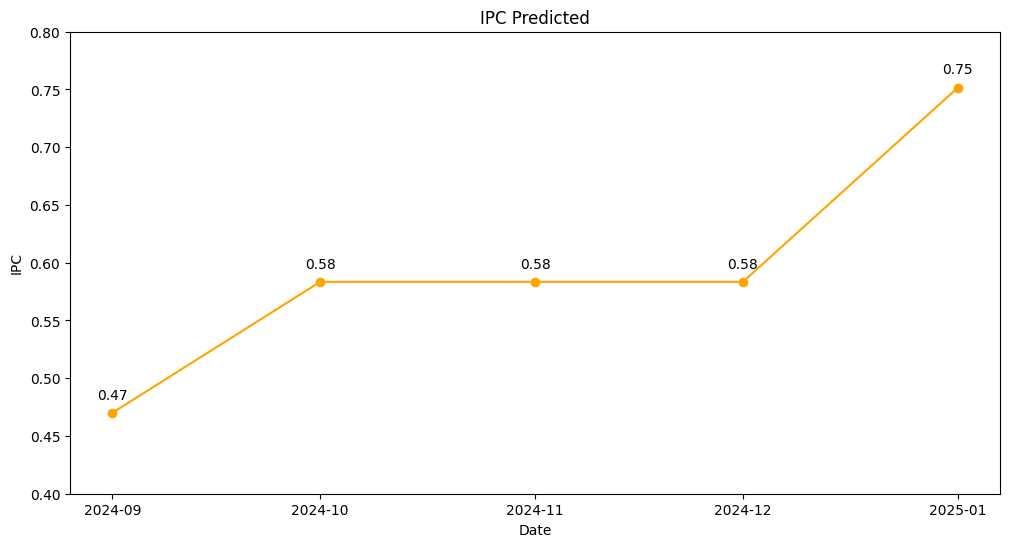

In [141]:
plt.figure(figsize=(12, 6))
plt.ylim(0.4, 0.8)
plt.plot(df2['ipc'].iloc[-5:], color='orange')
plt.plot(df2['ipc'].iloc[-5:], 'o', color='orange')

for i, value in enumerate(df2['ipc'].iloc[-5:]):
    plt.annotate(f'{value:.2f}', (df2.index[-5:][i], value), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Date')
plt.ylabel('IPC')
plt.title("IPC Predicted")
plt.xticks(df2.index[-5:], df2.index[-5:].strftime('%Y-%m'))
plt.show()

In [133]:
predicciones = []
x_test_cpy = x_test.copy()
for i in range(1,5):
   prediccion = grid_search.predict(x_test_cpy)[-1]

   ultimas_caracteristicas = x_test_cpy.tail(1)
   row = ultimas_caracteristicas.copy()

   row["month"] = row["month"] + 1
   predicciones.append((row.index,prediccion))
   row.index = row.index + pd.DateOffset(months=1)

   row['ipc-1'] = prediccion
   row_copy = row.copy()
   for j in range(1,12):
    row[f'ipc-{j+1}'] = row_copy[f'ipc-{j}']

   x_test_cpy = pd.concat([x_test_cpy, row])

x_test_cpy.tail()

,year,month,ipc-1,ipc-2,ipc-3,ipc-4,ipc-5,ipc-6,ipc-7,ipc-8,ipc-9,ipc-10,ipc-11,ipc-12
date,,,,,,,,,,,,,,
2024-08-01,2024,8,0.350000,0.410000,0.350000,0.300000,0.780000,0.78,1.56,0.54,0.57,0.17,0.39,0.53
2024-09-01,2024,9,0.583465,0.583465,0.410000,0.350000,0.300000,0.78,0.78,1.56,0.54,0.57,0.17,0.39
2024-10-01,2024,10,0.335935,0.335935,0.583465,0.410000,0.350000,0.30,0.78,0.78,1.56,0.54,0.57,0.17
2024-11-01,2024,11,0.507154,0.507154,0.335935,0.583465,0.410000,0.35,0.30,0.78,0.78,1.56,0.54,0.57
2024-12-01,2024,12,0.583465,0.583465,0.507154,0.335935,0.583465,0.41,0.35,0.30,0.78,0.78,1.56,0.54


In [134]:
predicciones
data = []
for date, prediction in predicciones:
    data.append({'date': date[0], 'prediction': prediction})
df_predictions = pd.DataFrame(data)
df_predictions.set_index('date', inplace=True)
df_predictions

,prediction
date,
2024-08-01,0.583465
2024-09-01,0.335935
2024-10-01,0.507154
2024-11-01,0.583465


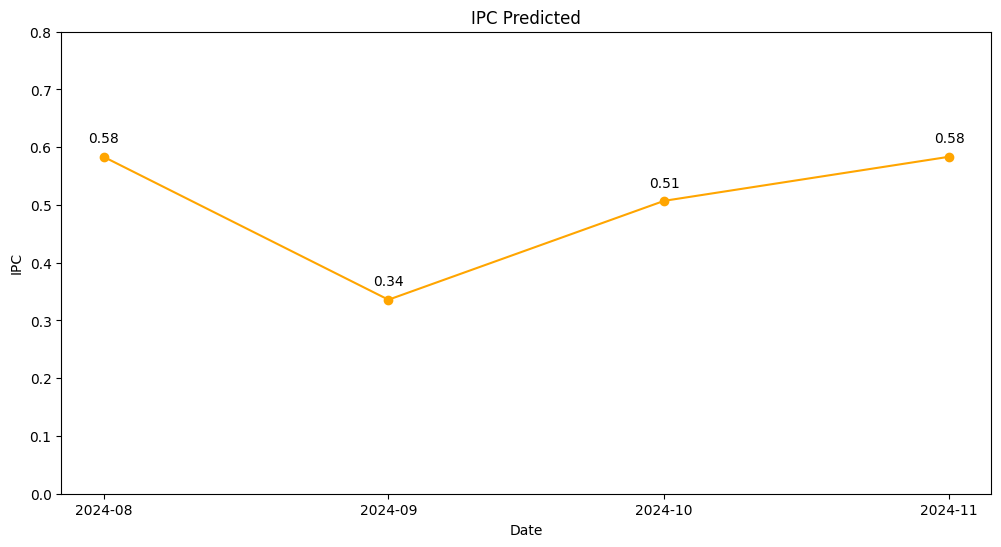

In [137]:
plt.figure(figsize=(12, 6))
plt.ylim(0, 0.8)
plt.plot(df_predictions['prediction'].iloc[-5:], color='orange')
plt.plot(df_predictions['prediction'].iloc[-5:], 'o', color='orange')

for i, value in enumerate(df_predictions['prediction'].iloc[-5:]):
    plt.annotate(f'{value:.2f}', (df_predictions.index[-5:][i], value), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Date')
plt.ylabel('IPC')
plt.title("IPC Predicted")
plt.xticks(df_predictions.index[-5:], df_predictions.index[-5:].strftime('%Y-%m'))
plt.show()

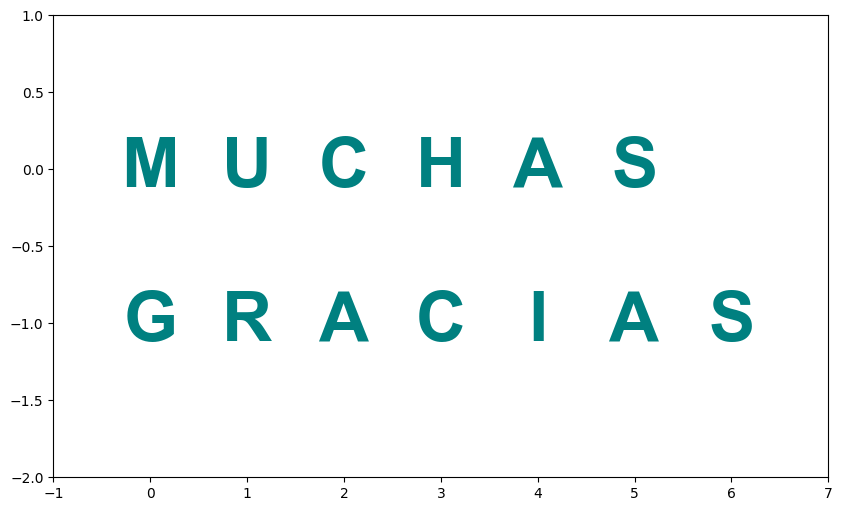

In [132]:
fig, ax = plt.subplots(figsize=(10, 6))

words = ["MUCHAS", "GRACIAS"]
positions = {
    "MUCHAS": [(i, 0) for i in range(len("MUCHAS"))],
    "GRACIAS": [(i, -1) for i in range(len("GRACIAS"))]
}

for word in words:
    for (i, letter) in enumerate(word):
        ax.text(positions[word][i][0], positions[word][i][1], letter, fontsize=50, ha='center', va='center', family='arial', fontweight='bold', color='teal')

ax.set_xlim(-1, 7)
ax.set_ylim(-2, 1)
plt.show()